In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.special import expit, logit
from sklearn.preprocessing import scale

np.random.seed(1)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

# Prepare the data

In [2]:
# load
df = pd.read_pickle('../data/process/schools2017.pkl')

# select columns
df = df[[
    'Percent of Students Chronically Absent',
    
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
    
    '# Students in HS Admissions',
    '# SHSAT Testers',
    '% SHSAT Testers',
]].copy()
print(df.shape[0], "schools")

# drop schools with missing test data
df = df[df.loc[:, 'Mean Scale Score - ELA':'% Level 4 - Math'].notnull().all(axis=1)]
print(df.shape[0], "schools after dropping missing test data")

# some schools have no presence information
presenceok = df['Percent of Students Chronically Absent'].notnull()

# schools with 0-5 SHSAT testers have this value set to NaN
applicantsok = df['# SHSAT Testers'].notnull()

# convert percentages to the (0, 1) range
bad_pct_c = [
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]
df.loc[:, bad_pct_c] = df.loc[:, bad_pct_c] / 100.0

# standardize score columns (ease of interpretation + algorithm stability)
score_c = ['Mean Scale Score - ELA', 'Mean Scale Score - Math']
df.loc[:, score_c] = df.loc[:, score_c].apply(scale)

594 schools
588 schools after dropping missing test data


# Create models

- Model 1: for schools with no presence information
- Model 2: for schools with presence information

In [3]:
# model 1 ----

# data
in_columns = [
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]
inputs = df[applicantsok][in_columns]
outputs = df[applicantsok]['% SHSAT Testers']
to_predict = df[~presenceok][in_columns]

# prepare inputs
inputs['Constant'] = 1.0
to_predict['Constant'] = 1.0

# prepare outputs
outputs = logit(outputs)

# fit
model = sm.RLM(outputs, inputs, M=sm.robust.norms.HuberT())
results = model.fit()

# predict
predictions = model.predict(results.params, exog=to_predict)

# export
predictions_model1 = pd.Series(predictions, index=to_predict.index)
predictions_model1.name = 'Predictions'

In [4]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:        % SHSAT Testers   No. Observations:                  533
Model:                            RLM   Df Residuals:                      524
Method:                          IRLS   Df Model:                            8
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 02 Aug 2018                                         
Time:                        20:01:48                                         
No. Iterations:                    21                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Mean Scale Score - ELA      0.2914      0.263      1.107      0.268      -0.225       0.807
% Level 2 - ELA            -0.2863      0.935     -0.306      0.759      -2.118       1.545
% Level 3 - ELA            -0.1035      1.226     -0.084      0.933      -2.506       2.299
% Level 4 - ELA            -0.0299      1.819     -0.016      0.987      -3.595       3.535
Mean Scale Score - Math     0.2006      0.265      0.757      0.449      -0.319       0.720
% Level 2 - Math           -0.4865      0.739     -0.658      0.510      -1.935       0.962
% Level 3 - Math            0.3992      0.920      0.434      0.664      -1.404       2.203
% Level 4 - Math            1.4859      1.372      1.083      0.279      -1.203       4.175
Constant                   -0.8712      1.042     -0.836      0.403      -2.914       1.172
===========================================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

In [5]:
# model 2 ----

# data
in_columns = [
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',    
    'Percent of Students Chronically Absent',
]
inputs = df[presenceok & applicantsok][in_columns]
outputs = df[presenceok & applicantsok]['% SHSAT Testers']
to_predict = df[presenceok][in_columns]

# prepare inputs
inputs['Constant'] = 1.0
to_predict['Constant'] = 1.0

# prepare outputs
outputs = logit(outputs)

# fit
model = sm.RLM(outputs, inputs, M=sm.robust.norms.HuberT())
results = model.fit()

# predict
predictions = model.predict(results.params, exog=to_predict)
predictions.shape

# export
predictions_model2 = pd.Series(predictions, index=to_predict.index)
predictions_model2.name = 'Predictions'

In [6]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:        % SHSAT Testers   No. Observations:                  523
Model:                            RLM   Df Residuals:                      513
Method:                          IRLS   Df Model:                            9
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 02 Aug 2018                                         
Time:                        20:01:48                                         
No. Iterations:                    25                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Mean Scale Score - ELA                     0.2684      0.262      1.026      0.305      -0.244       0.781
% Level 2 - ELA                           -0.3724      0.931     -0.400      0.689      -2.196       1.451
% Level 3 - ELA                            0.2655      1.226      0.217      0.829      -2.137       2.668
% Level 4 - ELA                           -0.3891      1.810     -0.215      0.830      -3.936       3.158
Mean Scale Score - Math                    0.1618      0.264      0.612      0.541      -0.356       0.680
% Level 2 - Math                          -0.7423      0.737     -1.008      0.314      -2.186       0.701
% Level 3 - Math                           0.2076      0.915      0.227      0.821      -1.586       2.001
% Level 4 - Math                           1.8298      1.366      1.339      0.181      -0.848       4.508
Percent of Students Chronically Absent    -0.5718      0.353     -1.621      0.105      -1.263       0.120
Constant                                  -0.7013      1.046     -0.670      0.503      -2.752       1.350
==========================================================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

In [7]:
# join predictions
predictions = pd.concat([predictions_model1, predictions_model2])

# Arrange results

In [8]:
def from_counts(shsat_counts, hs_counts):
    return pd.DataFrame({
        'logit': logit(shsat_counts / hs_counts),
        'pct': shsat_counts / hs_counts,
        'cnt': shsat_counts,
    })

def from_logits(shsat_logits, hs_counts):
    return pd.DataFrame({
        'logit': shsat_logits,
        'pct': expit(shsat_logits),
        'cnt': expit(shsat_logits) * hs_counts,
    })

In [9]:
# actual values  ---

# schools with 0 to 5 applicants
hs_counts = df[~applicantsok]['# Students in HS Admissions']
min_v = from_counts(0, hs_counts)
max_v = from_counts(5, hs_counts)

# schools with 6 or more applicants
shsat_counts = df[applicantsok]['# SHSAT Testers']
hs_counts = df[applicantsok]['# Students in HS Admissions']
pontual_v = from_counts(shsat_counts, hs_counts)


# estimated values  ---

shsat_logits = predictions
hs_counts = df['# Students in HS Admissions']
estimated_v = from_logits(shsat_logits, hs_counts)


# differences  ---

min_diff = (min_v - estimated_v).dropna()
max_diff = (max_v - estimated_v).dropna()
pontual_diff = (pontual_v - estimated_v).dropna()


# join everything together  ---

# actual
actual = pd.DataFrame({
    'Actual Cnt (min)': pd.concat([min_v, pontual_v])['cnt'],
    'Actual Cnt (max)': pd.concat([max_v, pontual_v])['cnt'],
    'Actual Pct (min)': pd.concat([min_v, pontual_v])['pct'],
    'Actual Pct (max)': pd.concat([max_v, pontual_v])['pct'],
})

# estimated / expected
estimated = pd.DataFrame({
    'Estimated Cnt': estimated_v['cnt'],
    'Estimated Pct': estimated_v['pct'],
})

# diff
difference = pd.DataFrame({
    'Diff Cnt (min)': pd.concat([min_diff, pontual_diff])['cnt'],
    'Diff Cnt (max)': pd.concat([max_diff, pontual_diff])['cnt'],
    'Diff Pct (min)': pd.concat([min_diff, pontual_diff])['pct'],
    'Diff Pct (max)': pd.concat([max_diff, pontual_diff])['pct'],
    
    'Chance Multiplier': np.exp(pd.concat([max_diff, pontual_diff])['logit']),  # note - max diff
})

# everything
everything = actual.join(estimated).join(difference)
everything = everything.sort_index()
everything.head()

,Actual Cnt (min),Actual Cnt (max),Actual Pct (min),Actual Pct (max),Estimated Cnt,Estimated Pct,Diff Cnt (min),Diff Cnt (max),Diff Pct (min),Diff Pct (max),Chance Multiplier
DBN,,,,,,,,,,,
01M034,6.0,6.0,0.103448,0.103448,9.967794,0.171859,-3.967794,-3.967794,-0.068410,-0.068410,0.556008
01M140,6.0,6.0,0.089552,0.089552,10.965396,0.163663,-4.965396,-4.965396,-0.074110,-0.074110,0.502636
01M184,67.0,67.0,0.761364,0.761364,55.454716,0.630167,11.545284,11.545284,0.131196,0.131196,1.872428
01M188,0.0,5.0,0.000000,0.084746,9.707071,0.164527,-9.707071,-4.707071,-0.164527,-0.079781,0.470189
01M301,11.0,11.0,0.215686,0.215686,10.044904,0.196959,0.955096,0.955096,0.018727,0.018727,1.121230


In [14]:
everything.sort_values('Chance Multiplier').head()

,Actual Cnt (min),Actual Cnt (max),Actual Pct (min),Actual Pct (max),Estimated Cnt,Estimated Pct,Diff Cnt (min),Diff Cnt (max),Diff Pct (min),Diff Pct (max),Chance Multiplier
DBN,,,,,,,,,,,
02M408,9.0,9.0,0.272727,0.272727,24.202615,0.733413,-15.202615,-15.202615,-0.460685,-0.460685,0.136308
84M336,15.0,15.0,0.159574,0.159574,52.589193,0.559460,-37.589193,-37.589193,-0.399885,-0.399885,0.149514
84M353,0.0,5.0,0.000000,0.049505,25.383446,0.251321,-25.383446,-20.383446,-0.251321,-0.201816,0.155155
09X117,0.0,5.0,0.000000,0.028571,24.184993,0.138200,-24.184993,-19.184993,-0.138200,-0.109629,0.183409
32K554,22.0,22.0,0.372881,0.372881,42.120238,0.713902,-20.120238,-20.120238,-0.341021,-0.341021,0.238285


# Usage example

PASSNYC wants to find a school where it has the biggest chance of bringing new students to sit for the SHSAT.

In [187]:
# generate a simple table for visualization first

school_info = pd.read_pickle('../data/process/schools2017.pkl')
school_info = school_info[[
    'Borough',
    
    'Percent Hispanic',
    'Percent Black',
    'Percent White',
    'Percent Asian',
    
    'Economic Need Index',
    'Percent English Language Learners',
    'Percent Students with Disabilities',
    'Percent of Students Chronically Absent',
    
    '% Level 4 - ELA',
    '% Level 4 - Math',
    
    '# Students in HS Admissions',
]]

school_info.columns = [
    'Borough',
    
    'Hispanic',
    'Black',
    'White',
    'Asian',
    
    'Economic Need Index',
    'ELL',
    'Special Education',
    'Chronically Absent',
    
    'ELA 4s',
    'Math 4s',
    
    'HS Admissions',
]

school_info['ELA 4s'] /= 100.0
school_info['Math 4s'] /= 100.0

In [188]:
def join_range(x1, x2):
    x1, x2 = sorted([x1, x2])
    x1 = np.round(x1).astype(int)
    x2 = np.round(x2).astype(int)
    if x1 == x2:
        return "{}".format(x1)
    else:
        return "{}-{}".format(x1, x2)
    
expected_cnt = everything.apply(lambda x: join_range(x['Estimated Cnt'], x['Estimated Cnt']), axis=1)
actual_cnt = everything.apply(lambda x: join_range(x['Actual Cnt (min)'], x['Actual Cnt (max)']), axis=1)
diff_cnt = everything.apply(lambda x: join_range(-x['Diff Cnt (min)'], -x['Diff Cnt (max)']), axis=1)

school_info['Testers (Exp)'] = expected_cnt
school_info['Testers (Actual)'] = actual_cnt
school_info['Testers (Diff)'] = diff_cnt

In [189]:
index = everything.sort_values('Chance Multiplier').index
school_info = school_info.reindex(index)

In [190]:
format_dict = {
    'Hispanic': '{:.0%}',
    'Black': '{:.0%}',
    'White': '{:.0%}',
    'Asian': '{:.0%}',
    
    'Economic Need Index': '{:.2f}',
    'ELL': '{:.0%}',
    'Special Education': '{:.0%}',
    'Chronically Absent': '{:.0%}',
    
    'ELA 4s': '{:.0%}',
    'Math 4s': '{:.0%}',
    
    'HS Admissions': '{:.0f}',
}
school_info.head(25).style.format(format_dict)

,Borough,Hispanic,Black,White,Asian,Economic Need Index,ELL,Special Education,Chronically Absent,ELA 4s,Math 4s,HS Admissions,Testers (Exp),Testers (Actual),Testers (Diff)
DBN,,,,,,,,,,,,,,,
02M408,manhattan,18%,17%,45%,10%,0.20,0%,12%,6%,75%,44%,33,24,9,15
84M336,manhattan,68%,30%,1%,0%,0.79,14%,23%,16%,21%,40%,94,53,15,38
84M353,manhattan,96%,4%,0%,0%,0.83,15%,14%,8%,5%,2%,101,25,0-5,20-25
09X117,bronx,79%,18%,1%,2%,0.90,40%,28%,25%,1%,0%,175,24,0-5,19-24
32K554,brooklyn,78%,7%,10%,5%,0.57,0%,1%,6%,46%,46%,59,42,22,20
27Q207,queens,18%,2%,75%,3%,0.14,0%,21%,9%,11%,24%,83,38,14,24
06M348,manhattan,96%,2%,1%,0%,0.82,19%,22%,18%,5%,1%,87,20,6,14
14K582,brooklyn,71%,23%,4%,0%,0.78,12%,34%,23%,5%,0%,100,18,0-5,13-18
06M528,manhattan,96%,2%,0%,1%,0.81,23%,19%,6%,0%,8%,75,17,0-5,12-17


In [198]:
df.loc['84M353']  # why do we expect 25 testers?

Percent of Students Chronically Absent      0.079000
Mean Scale Score - ELA                      0.218267
% Level 2 - ELA                             0.531915
% Level 3 - ELA                             0.351064
% Level 4 - ELA                             0.053191
Mean Scale Score - Math                    -0.036026
% Level 2 - Math                            0.478723
% Level 3 - Math                            0.212766
% Level 4 - Math                            0.021277
# Students in HS Admissions               101.000000
# SHSAT Testers                                  NaN
% SHSAT Testers                                  NaN
Name: 84M353, dtype: float64

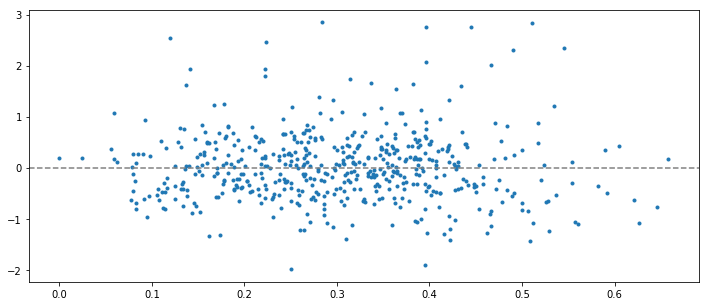

In [197]:
xs = df['% Level 3 - ELA'][applicantsok]
ys = (logit(df['% SHSAT Testers']) - predictions)[applicantsok]

plt.figure(figsize=(12, 5))
plt.plot(xs, ys, '.')
plt.axhline(0, color='gray', linestyle='--')